In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
import numpy as np
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
import pickle
from model_preparation import plotting, smape_loss, datasplit
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
# Load the Excel file
df_origin = pd.read_csv('20230411_SummerTerm23_Data_Challenge_Infineon_Data.csv')
stockprice = pd.read_csv('stockprice.csv')
# delete discontinuing products
df_continue = df_origin[df_origin['reporting_time'] == '2023-02-01T00:00:00.000Z']
df_continue_origin = df_origin[df_origin['product_name'].isin(df_continue['product_name'])]

# Check number of datapoints
product_counts = df_continue_origin['product_name'].value_counts()
i = 0
for name in tqdm(df_continue_origin['product_name'].unique()):
    # if we have enough data points
    if product_counts[name] < 19:
        i = i + 1
print(i)
# result dictionaries
result_rf = {}
result_rf_temp = []
result_rf_less80 = {}
result_rf_other = {}
result_rf_stock = {}
result_rf_stock_other = {}
# Use previous 15 data to predict next demand
step = 15
future_periods = 18

C:\Users\user\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
100%|██████████| 1392/1392 [00:00<00:00, 67489.75it/s]

123


### Visualization for RF hyperparameter tuning

Text(0.5, 1.0, 'After')

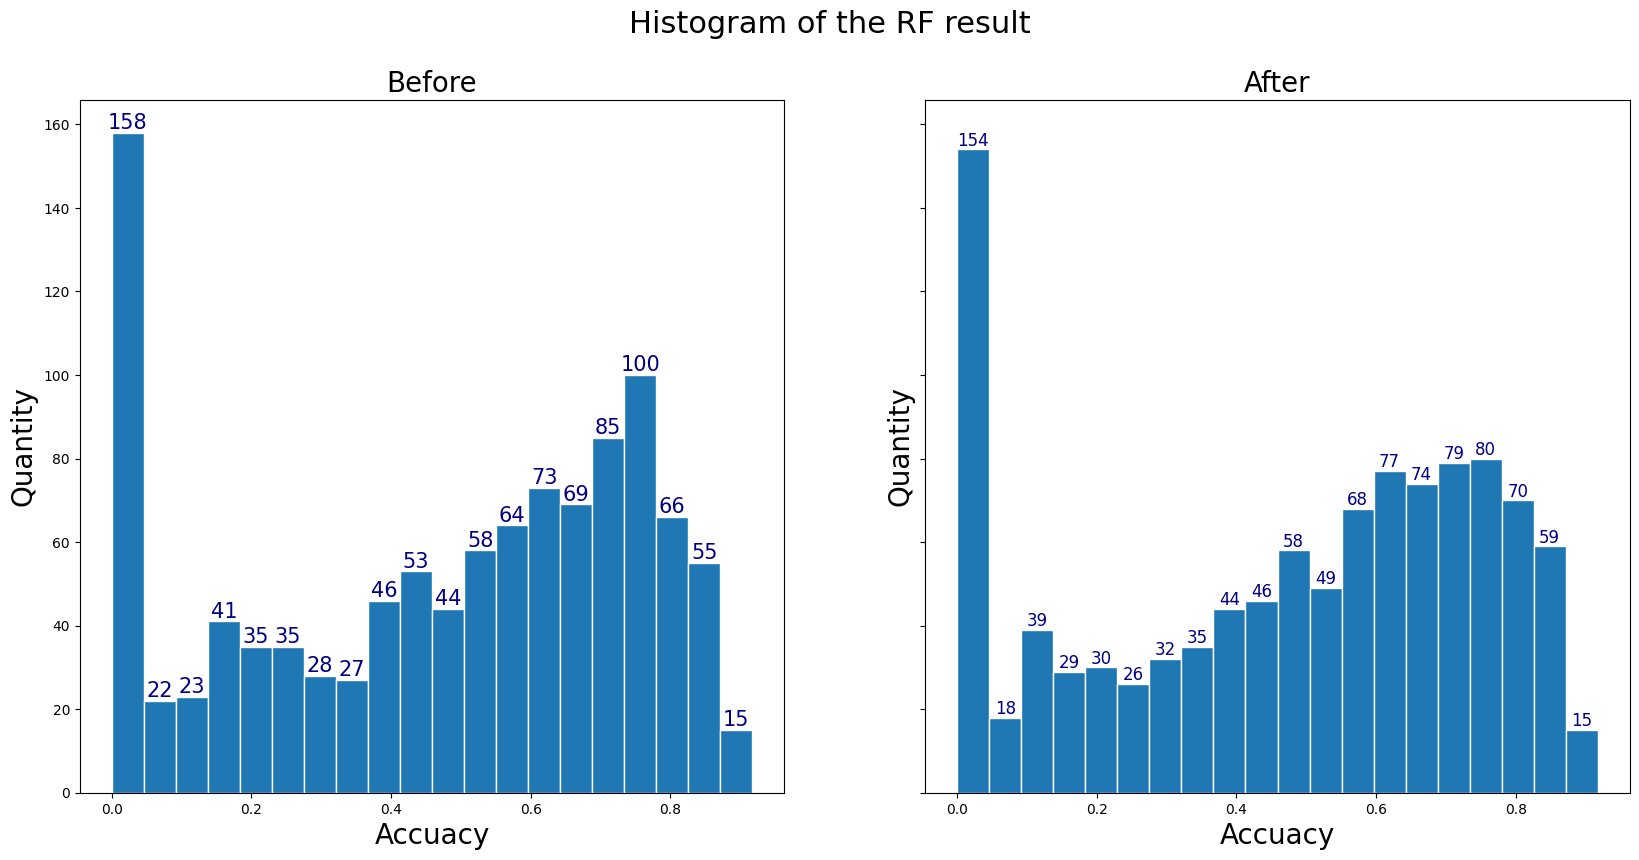

In [10]:
result_g08 = {key: value for key, value in result.items() if value[0] > 0.8}
result_hype_g08 = {key: value for key, value in result_hype.items() if value[0] > 0.8}
result_stock_g08 = {key: value for key, value in result_stock.items() if value[0] > 0.8}
final = result_g08|result_hype_g08|result_stock_g08|result_stockhype
fig, (ax1, ax2) = plt.subplots(1,2, sharex='col', sharey='row', figsize=(20,9))
fig.suptitle('Histogram of the RF result', fontsize=22)
first_values = [result[key][0] for key in result if 'nan' not in str(result[key][0])]
values, bins, bars = ax1.hist(first_values, edgecolor='white', bins=20)
ax1.set_xlabel('Accuacy', fontsize=20)
ax1.set_ylabel('Quantity', fontsize=20)
ax1.bar_label(bars, fontsize=15, color='navy')
ax1.set_title('Before', fontsize=20)
second_values = [final[key][0] for key in final if 'nan' not in str(final[key][0])]
values, bins, bars = ax2.hist(second_values, edgecolor='white', bins=20)
ax2.set_xlabel('Accuacy', fontsize=20)
ax2.set_ylabel('Quantity', fontsize=20)
ax2.bar_label(bars, fontsize=12, color='navy')
ax2.set_title('After', fontsize=20)

In [10]:
def Average(lst):
    return sum(lst) / len(lst)
 
# Driver Code
average_f = Average(first_values)
average_s = Average(second_values)
average_f, average_s

### RF hyperparameter tuning

In [ ]:
for name in tqdm(df_continue_origin['product_name'].unique()):
    # if we have enough data points
    if product_counts[name] > 21:
        df_product = df_continue_origin.loc[df_continue_origin['product_name'] == name]
        df_product = df_product.sort_values(by='reporting_time', ascending=True)
        # calculate the correlation between each feature and demand and choose the first 8 features
        corr_matrix = df_product.corr()
        demand_corr = corr_matrix.sort_values(by=['demand'], ascending=False)
        index_list = demand_corr.index.tolist()
        df = df_product[index_list[0:8]]
        df_copy = df.copy(deep=True)

        # Create lagged features
        for i in range(1, step + 1):
            for j in df_copy.columns.tolist():
                df[j + f"_{i}"] = df_copy[j].shift(i)
        # Split the data into training and testing sets
        train_size = int(len(df) * 0.8)  # 80% for training, 20% for testing
        train_data = df[:train_size]
        test_data = df[train_size:]
        # Prepare the feature matrix and target variable for training
        X_train = train_data.dropna().drop(df_copy.columns.tolist()[0:8], axis=1)
        y_train = train_data.dropna()[df_copy.columns.tolist()[0:8]]

        # Train the Random Forest model
        rf_model = RandomForestRegressor()
        rf_model.fit(X_train, y_train)
        kurs = "RF_model/%s.joblib" % name
        joblib.dump(rf_model, kurs)
        # Prepare the feature matrix and target variable for testing
        X_test = test_data.dropna().drop(df_copy.columns.tolist()[0:8], axis=1)
        y_test = test_data.dropna()[df_copy.columns.tolist()[0:8]]
        # Make predictions
        predictions = pd.DataFrame(rf_model.predict(X_test), columns=y_test.columns)

        # Calculate the smape
        smape = smape_loss(y_test['demand'], predictions['demand'])
        accuracy = 1 - smape
        # Generate future dates for prediction
        future = pd.DataFrame(index=pd.Index(list(range(future_periods))), columns=X_train.columns)
        future_all = pd.DataFrame(index=pd.Index(list(range(1))), columns=df.columns)
        future_all.iloc[0, :] = df.iloc[-1, :]
        for i in range(future_periods):
            future.iloc[i, :] = future_all.iloc[-1, 0:(len(df.columns.tolist())-8)]
            test_future = pd.DataFrame([list(future.iloc[i, :])], columns=X_train.columns)
            future_data = pd.DataFrame(rf_model.predict(test_future), columns=df.columns[0:8])
            future_all.loc[i+1, :] = pd.concat([future_data, test_future], axis=1).iloc[0, :]
        future_all = future_all[1:len(future_all)]

        actual = df_copy.reset_index(drop=True)['demand']
        predict = predictions['demand']
        predict.index = list(range(len(actual) - len(predict), len(actual)))
        future_all.index = list(range(len(actual), len(actual) + future_periods))
        plt.figure(figsize=(12, 6))
        plt.plot(actual, label="Actual Demand")
        plt.plot(predict, label="Predicted Demand")
        plt.plot(future_all['demand'], label="Future Demand")
        plt.xlabel("Months")
        plt.ylabel("Demand")
        percent_string = '%'
        plt.title("Actual vs Predicted Demand: %s, test accuracy: %s%s" % (
            name, round(100.00 * float(accuracy), 2), percent_string))
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True)
        kurs = "RF_plot/%s.png" % name
        plt.savefig(kurs, format='png')

        result_rf[name] = [accuracy, smape, future_all]
with open("RF_results/result.pkl", 'wb') as f:
    pickle.dump(result_rf, f)

### change result_stock or result

In [ ]:
for name in tqdm(result_stock.keys()):
    
    # if we have enough data points
    if result_stock[name][0] < 0.8:
        df_product = df_continue_origin.loc[df_continue_origin['product_name'] == name]
        df_product = df_product.sort_values(by='reporting_time', ascending=True)
        df_product.reset_index(drop=True, inplace=True)
        stock_price_cut = stockprice[-len(df_product):]
        stock_price_cut.reset_index(drop=True, inplace=True)
        df_update = pd.concat([df_product, stock_price_cut], axis=1)
        # calculate the correlation between each feature and demand and choose the first 8 features
        corr_matrix = df_update.corr()
        demand_corr = corr_matrix.sort_values(by=['demand'], ascending=False)
        index_list = demand_corr.index.tolist()
        df = df_update[index_list[0:8]]
        df_copy = df.copy(deep=True)

        # Create lagged features
        for i in range(1, step + 1):
            for j in df_copy.columns.tolist():
                df[j + f"_{i}"] = df_copy[j].shift(i)
        # Split the data into training and testing sets
        train_size = int(len(df) * 0.8)  # 80% for training, 20% for testing
        train_data = df[:train_size]
        test_data = df[train_size:]
        # Prepare the feature matrix and target variable for training
        X_train = train_data.dropna().drop(df_copy.columns.tolist()[0:8], axis=1)
        y_train = train_data.dropna()[df_copy.columns.tolist()[0:8]]

        # Train the Random Forest model
        rf_model = RandomForestRegressor()
        # Define the hyperparameter grid to search through
        param_grid = {
            'n_estimators': np.arange(10, 200, 40),
            'max_depth': [None] + list(np.arange(5, 30, 10)),
#             'min_samples_split': np.arange(2, 11),
#             'min_samples_leaf': np.arange(1, 11),
#             'bootstrap': [True, False]
        }

        # Initialize RandomizedSearchCV
        random_search = RandomizedSearchCV(
            estimator=rf_model,
            param_distributions=param_grid,
#             n_iter=100,  # Number of parameter settings that are sampled
            scoring=make_scorer(smape_loss, greater_is_better=False),
            cv=2,  # Cross-validation folds
#             random_state=42,
            n_jobs=-1  # Use all available CPU cores
        )
        # Fit the model to find the best hyperparameters
        random_search.fit(X_train, y_train)

        # Get the best hyperparameters and the best model
        best_params = random_search.best_params_
        best_model = random_search.best_estimator_
#         rf_model.fit(X_train, y_train)
#         kurs = "RF_model/%s.joblib" % name
#         joblib.dump(rf_model, kurs)
        # Prepare the feature matrix and target variable for testing
        X_test = test_data.dropna().drop(df_copy.columns.tolist()[0:8], axis=1)
        y_test = test_data.dropna()[df_copy.columns.tolist()[0:8]]
        # Make predictions
        predictions = pd.DataFrame(best_model.predict(X_test), columns=y_test.columns)

        # Calculate the smape
        smape = smape_loss(y_test['demand'], predictions['demand'])
        accuracy = 1 - smape
        # Generate future dates for prediction
        future = pd.DataFrame(index=pd.Index(list(range(future_periods))), columns=X_train.columns)
        future_all = pd.DataFrame(index=pd.Index(list(range(1))), columns=df.columns)
        future_all.iloc[0, :] = df.iloc[-1, :]
        for i in range(future_periods):
            future.iloc[i, :] = future_all.iloc[-1, 0:(len(df.columns.tolist())-8)]
            test_future = pd.DataFrame([list(future.iloc[i, :])], columns=X_train.columns)
            future_data = pd.DataFrame(best_model.predict(test_future), columns=df.columns[0:8])
            future_all.loc[i+1, :] = pd.concat([future_data, test_future], axis=1).iloc[0, :]
        future_all = future_all[1:len(future_all)]

        actual = df_copy.reset_index(drop=True)['demand']
        predict = predictions['demand']
        predict.index = list(range(len(actual) - len(predict), len(actual)))
        future_all.index = list(range(len(actual), len(actual) + future_periods))
#         plt.figure(figsize=(12, 6))
#         plt.plot(actual, label="Actual Demand")
#         plt.plot(predict, label="Predicted Demand")
#         plt.plot(future_all['demand'], label="Future Demand")
#         plt.xlabel("Months")
#         plt.ylabel("Demand")
#         percent_string = '%'
#         plt.title("Actual vs Predicted Demand: %s, test accuracy: %s%s" % (
#             name, round(100.00 * float(accuracy), 2), percent_string))
#         plt.legend()
#         plt.xticks(rotation=45)
#         plt.grid(True)
#         kurs = "RF_plot/%s.png" % name
#         plt.savefig(kurs, format='png')

        result_rf[name] = [accuracy, smape, future_all]
with open("RF_results/result_stockhype.pkl", 'wb') as f:
    pickle.dump(result_rf, f)

### calculating result adding stock as indicator

In [39]:
for name in tqdm(result_temp.keys()):
    if result_temp[name][0] < 0.8:
        if result_hype[name][0] < 0.8:
            df_product = df_continue_origin.loc[df_continue_origin['product_name'] == name]
            df_product = df_product.sort_values(by='reporting_time', ascending=True)
            df_product.reset_index(drop=True, inplace=True)
            stock_price_cut = stockprice[-len(df_product):]
            stock_price_cut.reset_index(drop=True, inplace=True)
            df_update = pd.concat([df_product, stock_price_cut], axis=1)
            # calculate the correlation between each feature and demand and choose the first 8 features
            corr_matrix = df_update.corr()
            demand_corr = corr_matrix.sort_values(by=['demand'], ascending=False)
            index_list = demand_corr.index.tolist()
            df = df_update[index_list[0:8]]
            df_copy = df.copy(deep=True)

            # Create lagged features
            for i in range(1, step + 1):
                for j in df_copy.columns.tolist():
                    df[j + f"_{i}"] = df_copy[j].shift(i)
            # Split the data into training and testing sets
            train_size = int(len(df) * 0.8)  # 80% for training, 20% for testing
            train_data = df[:train_size]
            test_data = df[train_size:]
            # Prepare the feature matrix and target variable for training
            X_train = train_data.dropna().drop(df_copy.columns.tolist()[0:8], axis=1)
            y_train = train_data.dropna()[df_copy.columns.tolist()[0:8]]

            # Train the Random Forest model
            rf_model = RandomForestRegressor()
            rf_model.fit(X_train, y_train)
    #         kurs = "RF_model/%s.joblib" % name
    #         joblib.dump(rf_model, kurs)
            # Prepare the feature matrix and target variable for testing
            X_test = test_data.dropna().drop(df_copy.columns.tolist()[0:8], axis=1)
            y_test = test_data.dropna()[df_copy.columns.tolist()[0:8]]
            # Make predictions
            predictions = pd.DataFrame(rf_model.predict(X_test), columns=y_test.columns)

            # Calculate the smape
            smape = smape_loss(y_test['demand'], predictions['demand'])
            accuracy = 1 - smape
            # Generate future dates for prediction
            future = pd.DataFrame(index=pd.Index(list(range(future_periods))), columns=X_train.columns)
            future_all = pd.DataFrame(index=pd.Index(list(range(1))), columns=df.columns)
            future_all.iloc[0, :] = df.iloc[-1, :]
            for i in range(future_periods):
                future.iloc[i, :] = future_all.iloc[-1, 0:(len(df.columns.tolist())-8)]
                test_future = pd.DataFrame([list(future.iloc[i, :])], columns=X_train.columns)
                future_data = pd.DataFrame(rf_model.predict(test_future), columns=df.columns[0:8])
                future_all.loc[i+1, :] = pd.concat([future_data, test_future], axis=1).iloc[0, :]
            future_all = future_all[1:len(future_all)]

    #         actual = df_copy.reset_index(drop=True)['demand']
    #         predict = predictions['demand']
    #         predict.index = list(range(len(actual) - len(predict), len(actual)))
    #         future_all.index = list(range(len(actual), len(actual) + future_periods))
    #         plt.figure(figsize=(12, 6))
    #         plt.plot(actual, label="Actual Demand")
    #         plt.plot(predict, label="Predicted Demand")
    #         plt.plot(future_all['demand'], label="Future Demand")
    #         plt.xlabel("Months")
    #         plt.ylabel("Demand")
    #         percent_string = '%'
    #         plt.title("Actual vs Predicted Demand: %s, test accuracy: %s%s" % (
    #             name, round(100.00 * float(accuracy), 2), percent_string))
    #         plt.legend()
    #         plt.xticks(rotation=45)
    #         plt.grid(True)
    #         kurs = "RF_plot/%s.png" % name
    #         plt.savefig(kurs, format='png')

            result_rf[name] = [accuracy, smape, future_all]
with open("RF_results/result_stock.pkl", 'wb') as f:
    pickle.dump(result_rf, f)

100%|██████████| 1252/1252 [07:27<00:00,  2.80it/s]


### hyperparameter tuning again

In [4]:
for name in tqdm(result_stock.keys()):
    
    # if we have enough data points
    if result_stock[name][0] < 0.8:
        df_product = df_continue_origin.loc[df_continue_origin['product_name'] == name]
        df_product = df_product.sort_values(by='reporting_time', ascending=True)
        df_product.reset_index(drop=True, inplace=True)
        stock_price_cut = stockprice[-len(df_product):]
        stock_price_cut.reset_index(drop=True, inplace=True)
        df_update = pd.concat([df_product, stock_price_cut], axis=1)
        # calculate the correlation between each feature and demand and choose the first 8 features
        corr_matrix = df_update.corr()
        demand_corr = corr_matrix.sort_values(by=['demand'], ascending=False)
        index_list = demand_corr.index.tolist()
        df = df_update[index_list[0:8]]
        df_copy = df.copy(deep=True)

        # Create lagged features
        for i in range(1, step + 1):
            for j in df_copy.columns.tolist():
                df[j + f"_{i}"] = df_copy[j].shift(i)
        # Split the data into training and testing sets
        train_size = int(len(df) * 0.8)  # 80% for training, 20% for testing
        train_data = df[:train_size]
        test_data = df[train_size:]
        # Prepare the feature matrix and target variable for training
        X_train = train_data.dropna().drop(df_copy.columns.tolist()[0:8], axis=1)
        y_train = train_data.dropna()[df_copy.columns.tolist()[0:8]]

        # Train the Random Forest model
        rf_model = RandomForestRegressor()
        # Define the hyperparameter grid to search through
        param_grid = {
            'n_estimators': np.arange(10, 200, 40),
            'max_depth': [None] + list(np.arange(5, 30, 10)),
#             'min_samples_split': np.arange(2, 11),
#             'min_samples_leaf': np.arange(1, 11),
#             'bootstrap': [True, False]
        }

        # Initialize RandomizedSearchCV
        random_search = RandomizedSearchCV(
            estimator=rf_model,
            param_distributions=param_grid,
#             n_iter=100,  # Number of parameter settings that are sampled
            scoring=make_scorer(smape_loss, greater_is_better=False),
            cv=2,  # Cross-validation folds
#             random_state=42,
            n_jobs=-1  # Use all available CPU cores
        )
        # Fit the model to find the best hyperparameters
        random_search.fit(X_train, y_train)

        # Get the best hyperparameters and the best model
        best_params = random_search.best_params_
        best_model = random_search.best_estimator_
#         rf_model.fit(X_train, y_train)
#         kurs = "RF_model/%s.joblib" % name
#         joblib.dump(rf_model, kurs)
        # Prepare the feature matrix and target variable for testing
        X_test = test_data.dropna().drop(df_copy.columns.tolist()[0:8], axis=1)
        y_test = test_data.dropna()[df_copy.columns.tolist()[0:8]]
        # Make predictions
        predictions = pd.DataFrame(best_model.predict(X_test), columns=y_test.columns)

        # Calculate the smape
        smape = smape_loss(y_test['demand'], predictions['demand'])
        accuracy = 1 - smape
        # Generate future dates for prediction
        future = pd.DataFrame(index=pd.Index(list(range(future_periods))), columns=X_train.columns)
        future_all = pd.DataFrame(index=pd.Index(list(range(1))), columns=df.columns)
        future_all.iloc[0, :] = df.iloc[-1, :]
        for i in range(future_periods):
            future.iloc[i, :] = future_all.iloc[-1, 0:(len(df.columns.tolist())-8)]
            test_future = pd.DataFrame([list(future.iloc[i, :])], columns=X_train.columns)
            future_data = pd.DataFrame(best_model.predict(test_future), columns=df.columns[0:8])
            future_all.loc[i+1, :] = pd.concat([future_data, test_future], axis=1).iloc[0, :]
        future_all = future_all[1:len(future_all)]

        actual = df_copy.reset_index(drop=True)['demand']
        predict = predictions['demand']
        predict.index = list(range(len(actual) - len(predict), len(actual)))
        future_all.index = list(range(len(actual), len(actual) + future_periods))
#         plt.figure(figsize=(12, 6))
#         plt.plot(actual, label="Actual Demand")
#         plt.plot(predict, label="Predicted Demand")
#         plt.plot(future_all['demand'], label="Future Demand")
#         plt.xlabel("Months")
#         plt.ylabel("Demand")
#         percent_string = '%'
#         plt.title("Actual vs Predicted Demand: %s, test accuracy: %s%s" % (
#             name, round(100.00 * float(accuracy), 2), percent_string))
#         plt.legend()
#         plt.xticks(rotation=45)
#         plt.grid(True)
#         kurs = "RF_plot/%s.png" % name
#         plt.savefig(kurs, format='png')

        result_rf[name] = [accuracy, smape, future_all]
with open("RF_results/result_stockhype.pkl", 'wb') as f:
    pickle.dump(result_rf, f)

100%|██████████| 980/980 [31:16<00:00,  1.91s/it]


In [ ]:
for name in tqdm(df_continue_origin['product_name'].unique()):
    # if we have enough data points
    if product_counts[name] > 21:
        df_product = df_continue_origin.loc[df_continue_origin['product_name'] == name]
        df_product = df_product.sort_values(by='reporting_time', ascending=True)
        # calculate the correlation between each feature and demand and choose the first 8 features
        corr_matrix = df_product.corr()
        demand_corr = corr_matrix.sort_values(by=['demand'], ascending=False)
        index_list = demand_corr.index.tolist()
        df = df_product[index_list[0:8]]
        df_copy = df.copy(deep=True)

        # Create lagged features
        for i in range(1, step + 1):
            for j in df_copy.columns.tolist():
                df[j + f"_{i}"] = df_copy[j].shift(i)
        # Split the data into training and testing sets
        train_size = int(len(df) * 0.8)  # 80% for training, 20% for testing
        train_data = df[:train_size]
        test_data = df[train_size:]
        # Prepare the feature matrix and target variable for training
        X_train = train_data.dropna().drop(df_copy.columns.tolist()[0:8], axis=1)
        y_train = train_data.dropna()[df_copy.columns.tolist()[0:8]]

        # Train the Random Forest model
        rf_model = RandomForestRegressor()
        rf_model.fit(X_train, y_train)
        kurs = "RF_model/%s.joblib" % name
        joblib.dump(rf_model, kurs)
        # Prepare the feature matrix and target variable for testing
        X_test = test_data.dropna().drop(df_copy.columns.tolist()[0:8], axis=1)
        y_test = test_data.dropna()[df_copy.columns.tolist()[0:8]]
        # Make predictions
        predictions = pd.DataFrame(rf_model.predict(X_test), columns=y_test.columns)

        # Calculate the smape
        smape = smape_loss(y_test['demand'], predictions['demand'])
        accuracy = 1 - smape
        # Generate future dates for prediction
        future = pd.DataFrame(index=pd.Index(list(range(future_periods))), columns=X_train.columns)
        future_all = pd.DataFrame(index=pd.Index(list(range(1))), columns=df.columns)
        future_all.iloc[0, :] = df.iloc[-1, :]
        for i in range(future_periods):
            future.iloc[i, :] = future_all.iloc[-1, 0:(len(df.columns.tolist())-8)]
            test_future = pd.DataFrame([list(future.iloc[i, :])], columns=X_train.columns)
            future_data = pd.DataFrame(rf_model.predict(test_future), columns=df.columns[0:8])
            future_all.loc[i+1, :] = pd.concat([future_data, test_future], axis=1).iloc[0, :]
        future_all = future_all[1:len(future_all)]

        actual = df_copy.reset_index(drop=True)['demand']
        predict = predictions['demand']
        predict.index = list(range(len(actual) - len(predict), len(actual)))
        future_all.index = list(range(len(actual), len(actual) + future_periods))
        plt.figure(figsize=(12, 6))
        plt.plot(actual, label="Actual Demand")
        plt.plot(predict, label="Predicted Demand")
        plt.plot(future_all['demand'], label="Future Demand")
        plt.xlabel("Months")
        plt.ylabel("Demand")
        percent_string = '%'
        plt.title("Actual vs Predicted Demand: %s, test accuracy: %s%s" % (
            name, round(100.00 * float(accuracy), 2), percent_string))
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True)
        kurs = "RF_plot/%s.png" % name
        plt.savefig(kurs, format='png')

        result_rf[name] = [accuracy, smape, future_all]
with open("RF_results/result.pkl", 'wb') as f:
    pickle.dump(result_rf, f)

### Random Forest cold start

In [ ]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
for i in ['reporting_time','product_application', 'product_main_family', 'product_marketing_name',
       'product_basic_type', 'planning_method_latest',
       'planning_method_reporting_month']:
    df_continue_origin[i] = labelencoder.fit_transform(df_continue_origin[i])

In [68]:
cold_start = {}
for name in tqdm(df_continue_origin['product_name'].unique()):
    # if we have enough data points
    if 5 > product_counts[name]:
        df_product_ref = df_continue_origin.loc[df_continue_origin['product_name'] == name].iloc[0]
        target_row = df_continue_origin[(df_continue_origin['product_basic_type'] == df_product_ref['product_basic_type'])]
        condition = target_row['product_name'] == name
        target_row = target_row.loc[~condition]
        # Split the data into training and testing sets
        train_size = int(len(target_row) * 0.8)  # 80% for training, 20% for testing
        train_data = target_row[:train_size]
        test_data = target_row[train_size:]
        # Prepare the feature matrix and target variable for training
        X_train = train_data.dropna().drop(df_continue_origin.columns.tolist()[0], axis=1)
        y_train = train_data.dropna()[df_continue_origin.columns.tolist()[2]]

        # Train the Random Forest model
        rf_model = RandomForestRegressor()
        try:
            rf_model.fit(X_train, y_train)
            # Prepare the feature matrix and target variable for testing
            X_test = test_data.dropna().drop(df_continue_origin.columns.tolist()[0], axis=1)
            y_test = test_data.dropna()[df_continue_origin.columns.tolist()[2]]
            # Make predictions
            predictions = list(rf_model.predict(X_test))

            # Calculate the smape
            smape = smape_loss(y_test.tolist(), predictions)
            accuracy = 1 - smape
            cold_start[name] = accuracy
        except:
            cold_start[name] = np.NaN

100%|██████████| 1392/1392 [00:06<00:00, 199.66it/s]


[Text(0, 0, '40'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '4'),
 Text(0, 0, '0'),
 Text(0, 0, '2'),
 Text(0, 0, '18')]

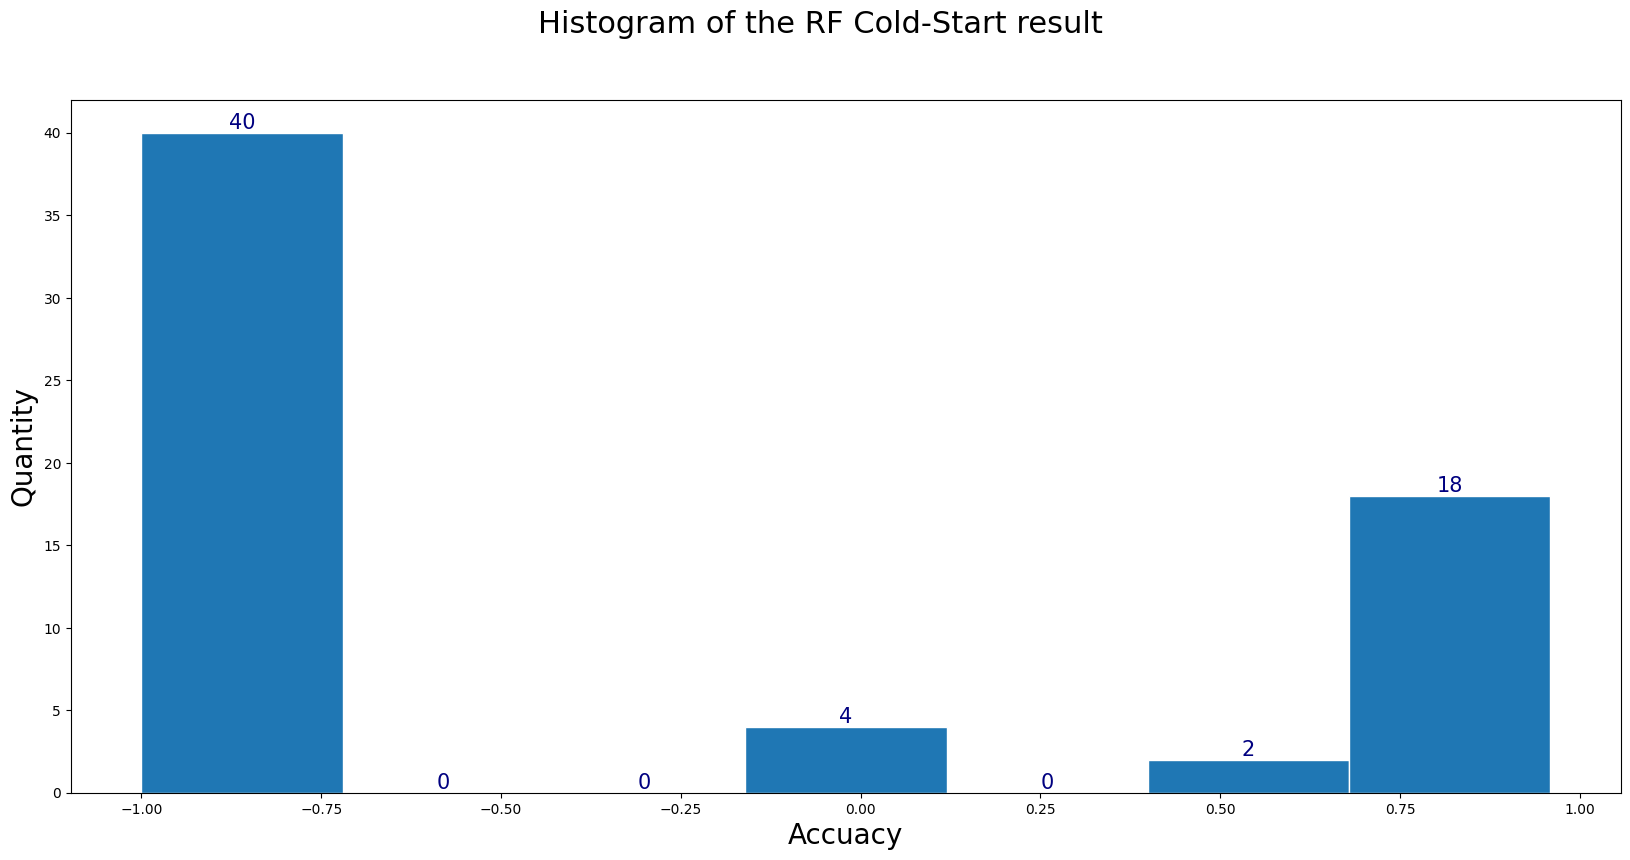

In [76]:
fig, ax1 = plt.subplots(1,1, sharex='col', sharey='row', figsize=(20,9))
fig.suptitle('Histogram of the RF Cold-Start result', fontsize=22)
first_values = [cold_start[key] for key in cold_start]
first_values = [val if not np.isnan(val) else -1 for val in first_values]
values, bins, bars = ax1.hist(first_values, edgecolor='white', bins=7)
# ax1.set_xlim(0, 1)
ax1.set_xlabel('Accuacy', fontsize=20)
ax1.set_ylabel('Quantity', fontsize=20)
ax1.bar_label(bars, fontsize=15, color='navy')
# ax1.set_title('Before', fontsize=20)

### Random Forset method

In [ ]:
for name in tqdm(df_continue_origin['product_name'].unique()):
    # if we have enough data points
    if product_counts[name] > 49:
        df_product = df_continue_origin.loc[df_continue_origin['product_name'] == name]
        df_product = df_product.sort_values(by='reporting_time', ascending=True)
        # calculate the correlation between each feature and demand and choose the first 8 features
        corr_matrix = df_product.corr()
        demand_corr = corr_matrix.sort_values(by=['demand'], ascending=False)
        index_list = demand_corr.index.tolist()
        df = df_product[index_list[0:8]]
        df_copy = df.copy(deep=True)

        # Create lagged features
        for i in range(1, step + 1):
            for j in df_copy.columns.tolist():
                df[j + f"_{i}"] = df_copy[j].shift(i)
        # Split the data into training and testing sets
        train_size = int(len(df) * 0.8)-18  # 80% for training, 20% for testing
        train_data = df[:train_size]
        test_data = df[train_size:len(df)-18]
        # Prepare the feature matrix and target variable for training
        X_train = train_data.dropna().drop(df_copy.columns.tolist()[0:8], axis=1)
        y_train = train_data.dropna()[df_copy.columns.tolist()[0:8]]

        # Train the Random Forest model
        rf_model = RandomForestRegressor()
        rf_model.fit(X_train, y_train)
#         kurs = "RF_model/%s.joblib" % name
#         joblib.dump(rf_model, kurs)
        # Prepare the feature matrix and target variable for testing
        X_test = test_data.dropna().drop(df_copy.columns.tolist()[0:8], axis=1)
        y_test = test_data.dropna()[df_copy.columns.tolist()[0:8]]
        # Make predictions
        predictions = pd.DataFrame(rf_model.predict(X_test), columns=y_test.columns)

        # Calculate the smape
        smape = smape_loss(y_test['demand'], predictions['demand'])
        accuracy = 1 - smape
        # Generate future dates for prediction
        future = pd.DataFrame(index=pd.Index(list(range(future_periods))), columns=X_train.columns)
        future_all = pd.DataFrame(index=pd.Index(list(range(1))), columns=df.columns)
        future_all.iloc[0, :] = df.iloc[-18, :]
        for i in range(future_periods):
            future.iloc[i, :] = future_all.iloc[-1, 0:(len(df.columns.tolist())-8)]
            test_future = pd.DataFrame([list(future.iloc[i, :])], columns=X_train.columns)
            future_data = pd.DataFrame(rf_model.predict(test_future), columns=df.columns[0:8])
            future_all.loc[i+1, :] = pd.concat([future_data, test_future], axis=1).iloc[0, :]
        future_all = future_all[1:len(future_all)]

        actual = df_copy.reset_index(drop=True)['demand']
        predict = predictions['demand']
        predict.index = list(range(len(actual) - len(predict)-18, len(actual)-18))
        future_all.index = list(range(len(actual)-18, len(actual)))
        future_accuracy = 1 - smape_loss(actual.iloc[len(actual) - 18:len(actual)], future_all['demand'])
        plt.figure(figsize=(12, 6))
        plt.plot(actual, label="Actual Demand")
        plt.plot(predict, label="Predicted Demand")
        plt.plot(future_all['demand'], label="Future Demand")
        plt.xlabel("Months")
        plt.ylabel("Demand")
        percent_string = '%'
        plt.title("Actual vs Predicted Demand: %s, test accuracy: %s%s, future accuracy: %s%s" % (
            name, round(100.00 * float(accuracy), 2), percent_string, round(100.00 * float(future_accuracy), 2), percent_string))
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True)
        kurs = "RF_plot/3618/%s.png" % name
        plt.savefig(kurs, format='png')

        result_rf[name] = [accuracy, smape, future_all, future_accuracy]
with open("RF_results/3618/result.pkl", 'wb') as f:
    pickle.dump(result_rf, f)

### Random Forset method with 36 months for training and testing, 18 months for future validation

In [ ]:
f_myfile = open("RF_results/3618/result.pkl", 'rb')
result_rf = pickle.load(f_myfile)
f_myfile.close()
result_stockhype = {}
for name in tqdm(result_stock.keys()):
    
    # if we have enough data points
    if result_stock[name][0] < 0.8:
        df_product = df_continue_origin.loc[df_continue_origin['product_name'] == name]
        df_product = df_product.sort_values(by='reporting_time', ascending=True)
        df_product.reset_index(drop=True, inplace=True)
        stock_price_cut = stockprice[-len(df_product):]
        stock_price_cut.reset_index(drop=True, inplace=True)
        df_update = pd.concat([df_product, stock_price_cut], axis=1)
#         calculate the correlation between each feature and demand and choose the first 8 features
        corr_matrix = df_update.corr()
        demand_corr = corr_matrix.sort_values(by=['demand'], ascending=False)
        index_list = demand_corr.index.tolist()
        df = df_update[index_list[0:8]]
        df_copy = df.copy(deep=True)

        # Create lagged features
        for i in range(1, step + 1):
            for j in df_copy.columns.tolist():
                df[j + f"_{i}"] = df_copy[j].shift(i)
        # Split the data into training and testing sets
        train_size = int(len(df) * 0.8)-18  # 80% for training, 20% for testing
        train_data = df[:train_size]
        test_data = df[train_size:len(df)-18]
        # Prepare the feature matrix and target variable for training
        X_train = train_data.dropna().drop(df_copy.columns.tolist()[0:8], axis=1)
        y_train = train_data.dropna()[df_copy.columns.tolist()[0:8]]

        # Train the Random Forest model
        rf_model = RandomForestRegressor()
        # Define the hyperparameter grid to search through
        param_grid = {
            'n_estimators': np.arange(10, 200, 40),
            'max_depth': [None] + list(np.arange(5, 30, 10)),
#             'min_samples_split': np.arange(2, 11),
#             'min_samples_leaf': np.arange(1, 11),
#             'bootstrap': [True, False]
        }

        # Initialize RandomizedSearchCV
        random_search = RandomizedSearchCV(
            estimator=rf_model,
            param_distributions=param_grid,
#             n_iter=100,  # Number of parameter settings that are sampled
            scoring=make_scorer(smape_loss, greater_is_better=False),
            cv=2,  # Cross-validation folds
#             random_state=42,
            n_jobs=-1  # Use all available CPU cores
        )
        # Fit the model to find the best hyperparameters
        random_search.fit(X_train, y_train)

        # Get the best hyperparameters and the best model
        best_params = random_search.best_params_
        best_model = random_search.best_estimator_
#         rf_model.fit(X_train, y_train)
#         kurs = "RF_model/%s.joblib" % name
#         joblib.dump(rf_model, kurs)
        # Prepare the feature matrix and target variable for testing
        X_test = test_data.dropna().drop(df_copy.columns.tolist()[0:8], axis=1)
        y_test = test_data.dropna()[df_copy.columns.tolist()[0:8]]
        # Make predictions
        predictions = pd.DataFrame(best_model.predict(X_test), columns=y_test.columns)

        # Calculate the smape
        smape = smape_loss(y_test['demand'], predictions['demand'])
        accuracy = 1 - smape
        # Generate future dates for prediction
        future = pd.DataFrame(index=pd.Index(list(range(future_periods))), columns=X_train.columns)
        future_all = pd.DataFrame(index=pd.Index(list(range(1))), columns=df.columns)
        future_all.iloc[0, :] = df.iloc[-18, :]
        for i in range(future_periods):
            future.iloc[i, :] = future_all.iloc[-1, 0:(len(df.columns.tolist())-8)]
            test_future = pd.DataFrame([list(future.iloc[i, :])], columns=X_train.columns)
            future_data = pd.DataFrame(best_model.predict(test_future), columns=df.columns[0:8])
            future_all.loc[i+1, :] = pd.concat([future_data, test_future], axis=1).iloc[0, :]
        future_all = future_all[1:len(future_all)]

        actual = df_copy.reset_index(drop=True)['demand']
        predict = predictions['demand']
        predict.index = list(range(len(actual) - len(predict)-18, len(actual)-18))
        future_all.index = list(range(len(actual)-18, len(actual)))
        future_accuracy = 1 - smape_loss(actual.iloc[len(actual) - 18:len(actual)], future_all['demand'])
        plt.figure(figsize=(12, 6))
        plt.plot(actual, label="Actual Demand")
        plt.plot(predict, label="Predicted Demand")
        plt.plot(future_all['demand'], label="Future Demand")
        plt.xlabel("Months")
        plt.ylabel("Demand")
        percent_string = '%'
        plt.title("Actual vs Predicted Demand: %s, test accuracy: %s%s, future accuracy: %s%s" % (
            name, round(100.00 * float(accuracy), 2), percent_string, round(100.00 * float(future_accuracy), 2), percent_string))
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True)
        kurs = "RF_plot/3618/%s.png" % name
        plt.savefig(kurs, format='png')

        result_stockhype[name] = [accuracy, smape, future_all, future_accuracy]
with open("RF_results/3618/result_stockhype.pkl", 'wb') as f:
    pickle.dump(result_stockhype, f)

In [ ]:
result_stock = {}
for name in tqdm(result_hype.keys()):
    if result_hype[name][0] < 0.8:
        df_product = df_continue_origin.loc[df_continue_origin['product_name'] == name]
        df_product = df_product.sort_values(by='reporting_time', ascending=True)
        df_product.reset_index(drop=True, inplace=True)
        stock_price_cut = stockprice[-len(df_product):]
        stock_price_cut.reset_index(drop=True, inplace=True)
        df_update = pd.concat([df_product, stock_price_cut], axis=1)
        # calculate the correlation between each feature and demand and choose the first 8 features
        corr_matrix = df_update.corr()
        demand_corr = corr_matrix.sort_values(by=['demand'], ascending=False)
        index_list = demand_corr.index.tolist()
        df = df_update[index_list[0:8]]
        df_copy = df.copy(deep=True)

        # Create lagged features
        for i in range(1, step + 1):
            for j in df_copy.columns.tolist():
                df[j + f"_{i}"] = df_copy[j].shift(i)
        # Split the data into training and testing sets
        train_size = int(len(df) * 0.8)-18  # 80% for training, 20% for testing
        train_data = df[:train_size]
        test_data = df[train_size:len(df)-18]
        # Prepare the feature matrix and target variable for training
        X_train = train_data.dropna().drop(df_copy.columns.tolist()[0:8], axis=1)
        y_train = train_data.dropna()[df_copy.columns.tolist()[0:8]]

        # Train the Random Forest model
        rf_model = RandomForestRegressor()
        rf_model.fit(X_train, y_train)
#         kurs = "RF_model/%s.joblib" % name
#         joblib.dump(rf_model, kurs)
        # Prepare the feature matrix and target variable for testing
        X_test = test_data.dropna().drop(df_copy.columns.tolist()[0:8], axis=1)
        y_test = test_data.dropna()[df_copy.columns.tolist()[0:8]]
        # Make predictions
        predictions = pd.DataFrame(rf_model.predict(X_test), columns=y_test.columns)

        # Calculate the smape
        smape = smape_loss(y_test['demand'], predictions['demand'])
        accuracy = 1 - smape
        # Generate future dates for prediction
        future = pd.DataFrame(index=pd.Index(list(range(future_periods))), columns=X_train.columns)
        future_all = pd.DataFrame(index=pd.Index(list(range(1))), columns=df.columns)
        future_all.iloc[0, :] = df.iloc[-18, :]
        for i in range(future_periods):
            future.iloc[i, :] = future_all.iloc[-1, 0:(len(df.columns.tolist())-8)]
            test_future = pd.DataFrame([list(future.iloc[i, :])], columns=X_train.columns)
            future_data = pd.DataFrame(rf_model.predict(test_future), columns=df.columns[0:8])
            future_all.loc[i+1, :] = pd.concat([future_data, test_future], axis=1).iloc[0, :]
        future_all = future_all[1:len(future_all)]

        actual = df_copy.reset_index(drop=True)['demand']
        predict = predictions['demand']
        predict.index = list(range(len(actual) - len(predict)-18, len(actual)-18))
        future_all.index = list(range(len(actual)-18, len(actual)))
        future_accuracy = 1 - smape_loss(actual.iloc[len(actual) - 18:len(actual)], future_all['demand'])
        plt.figure(figsize=(12, 6))
        plt.plot(actual, label="Actual Demand")
        plt.plot(predict, label="Predicted Demand")
        plt.plot(future_all['demand'], label="Future Demand")
        plt.xlabel("Months")
        plt.ylabel("Demand")
        percent_string = '%'
        plt.title("Actual vs Predicted Demand: %s, test accuracy: %s%s, future accuracy: %s%s" % (
            name, round(100.00 * float(accuracy), 2), percent_string, round(100.00 * float(future_accuracy), 2), percent_string))
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True)
        kurs = "RF_plot/3618/%s.png" % name
        plt.savefig(kurs, format='png')

        result_stock[name] = [accuracy, smape, future_all, future_accuracy]
with open("RF_results/result_stock.pkl", 'wb') as f:
    pickle.dump(result_stock, f)

In [16]:
result_g08 = {key: value for key, value in result.items() if value[0] > 0.8}
result_hype_g08 = {key: value for key, value in result_hype.items() if value[0] > 0.8}
result_stock_g08 = {key: value for key, value in result_stock.items() if value[0] > 0.8}
result_stockhype_g08 = {key: value for key, value in result_stockhype.items() if value[0] > 0.8}
final = result_g08|result_hype_g08|result_stock_g08|result_stockhype_g08
first_values = [final[key][-1] for key in final if 'nan' not in str(result[key][-1])]
len(first_values)

97

In [17]:
average_f = Average(first_values)
average_f

<tf.Tensor: shape=(), dtype=float32, numpy=0.70759237>